In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import lxml.etree as ET
from bs4 import BeautifulSoup
import os
import spacy
import string
import re
import math
import numpy as np
from spacy.symbols import ORTH
from pathlib import Path
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import cv2
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = Path("./generative-dog-images/all-dogs")
ANNOT_PATH = Path("./generative-dog-images/Annotation")
list(IMG_PATH.iterdir())[:10]

[PosixPath('generative-dog-images/all-dogs/n02109961_16718.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02113799_5009.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02091032_6587.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02106166_1429.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02093754_2276.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02107683_4411.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02094114_2625.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02088094_8631.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02097130_1289.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02095314_3084.jpg')]

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

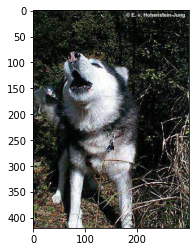

In [4]:
path = IMG_PATH/"n02109961_16718.jpg"
im = read_image(path)
plt.imshow(im)

In [5]:
im = cv2.imread(str(path))
im.shape

(420, 300, 3)

In [6]:
# let's look at the typical size of these images
images = list(IMG_PATH.iterdir())
annot_folders = list(ANNOT_PATH.iterdir())
annotations = []
for folder in annot_folders:
    breed_annots = list(folder.iterdir())
    annotations += breed_annots

In [7]:
images.sort(key = lambda x: str(x)[30:])
annotations.sort(key = lambda x: str(x)[33:])

In [8]:
images[:10]

[PosixPath('generative-dog-images/all-dogs/.DS_Store'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10074.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10131.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10621.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_1073.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10976.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11140.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11238.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11258.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11337.jpg')]

In [9]:
len(images)

20580

In [10]:
annotations[:10]

[PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10074'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10131'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10621'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_1073'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10976'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11140'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11238'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11258'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11337'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11477')]

In [11]:
len(annotations)

20580

In [12]:
annots_names = [str(x)[33:].split('/')[1] for x in annotations]
img_names = [str(x)[31:][:-4] for x in images]
set(annots_names)-set(img_names)

{'n02105855_2933'}

In [13]:
[str(x) for x in annotations].index('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

13680

In [14]:
annotations.pop(13680)

PosixPath('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

In [15]:
len(annotations)

20579

In [20]:
for i in range(len(annotations)):
    with open(annotations[i]) as file:  
        data = file.read()
    parser = ET.XMLParser(recover=True)
    tree = ET.ElementTree(ET.fromstring(data, parser=parser))
    for object in tree.findall('object'):
        breeds = []
        breeds.append((str(annotations[i]).split('/')[-1],
                       object.find('name').text))
    annotations[i] = breeds[0]

In [21]:
annotations[:10]

[('n02085620_10074', 'Chihuahua'),
 ('n02085620_10131', 'Chihuahua'),
 ('n02085620_10621', 'Chihuahua'),
 ('n02085620_1073', 'Chihuahua'),
 ('n02085620_10976', 'Chihuahua'),
 ('n02085620_11140', 'Chihuahua'),
 ('n02085620_11238', 'Chihuahua'),
 ('n02085620_11258', 'Chihuahua'),
 ('n02085620_11337', 'Chihuahua'),
 ('n02085620_11477', 'Chihuahua')]

In [22]:
len(annotations)

20579

## Resize Images

In [23]:
root = Path('generative-dog-images')
(root/'resized').mkdir(parents=True, exist_ok=True)

In [49]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [25]:
from os import listdir
from os.path import join
def resize_all_images(new_path=root/"resized/", old_path=IMG_PATH):
    orig_path = old_path
    failed_imgs = []
    for f in (orig_path).iterdir():
        try:
            img = get_a_crop(f)
        except: 
            failed_imgs.append(str(f.name))
            next
        path = new_path/f.name
        try:
            cv2.imwrite(str(path), img)
        except:
            failed_imgs.append(str(path))
    return failed_imgs

# imgs_failed = resize_all_images()

In [26]:
# Ignore these. They aren't images, so the didn't really "fail"
# imgs_failed

### Create DataFrame with Image Labels and Paths

In [27]:
resized = Path(root/'resized')
assert len(annotations) == len(list(resized.iterdir()))

In [36]:
str(train_df.f_name[0]).split('/')[-1][:-4]

'n02109961_16718'

In [41]:
train_df = pd.DataFrame({'f_name':list(resized.iterdir()),
                         'f_subname':[str(name).split('/')[-1][:-4] for name in list(resized.iterdir())]})
join_df = pd.DataFrame({'f_subname': [name[0] for name in annotations],
                        'label': [name[1] for name in annotations]})
train_df = pd.merge(train_df, join_df, on='f_subname', how='inner')
train_df.head()

,f_name,f_subname,label
0,generative-dog-images/resized/n02109961_16718.jpg,n02109961_16718,Eskimo_dog
1,generative-dog-images/resized/n02113799_5009.jpg,n02113799_5009,standard_poodle
2,generative-dog-images/resized/n02091032_6587.jpg,n02091032_6587,Italian_greyhound
3,generative-dog-images/resized/n02106166_1429.jpg,n02106166_1429,Border_collie
4,generative-dog-images/resized/n02093754_2276.jpg,n02093754_2276,Border_terrier


In [69]:
# train_df.to_csv("files.csv", index=False)

In [70]:
! open .

## Dataset

In [43]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

### Label to Index

In [62]:
label2index = {val:i for i, val in enumerate(sorted(set(train_df['label'])))}

In [54]:
class DogsDataset(Dataset):
    def __init__(self, df, transforms=False):
        self.df = df
        self.transforms = transforms
        self.files = np.array(df['f_name'])
        self.y = np.array(df['label'].map(label2index))
        
    def transform(self, x):
        rdeg = (np.random.random()-0.5)*20
        x = rotate_cv(x, rdeg)
        x = random_crop(x)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
        return x

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = str(self.files[idx])
        x = cv2.imread(path).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            x = self.transform(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

## Train Test Split

In [55]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size=0.2)

train_ds = DogsDataset(train, transforms=True)
valid_ds = DogsDataset(val, transforms=False)

In [56]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [57]:
next(iter(train_dl))

[tensor([[[[-0.0930, -0.9400, -1.0990,  ...,  0.2768,  0.9266,  1.4773],
           [-0.0625, -0.9790, -1.0776,  ...,  0.4654,  0.8861,  1.1021],
           [-0.0356, -1.0407, -1.0733,  ...,  0.2211,  0.2985,  0.3897],
           ...,
           [-0.2809, -0.2225, -0.2727,  ...,  0.8447,  0.8447,  0.8447],
           [-0.3541, -0.3605, -0.3969,  ...,  0.8447,  0.8447,  0.8447],
           [-0.3878, -0.4342, -0.4343,  ...,  0.8447,  0.8447,  0.8447]],
 
          [[-0.1386, -0.9939, -1.1560,  ...,  0.1870,  0.8354,  1.3892],
           [-0.1094, -1.0455, -1.1450,  ...,  0.3623,  0.7822,  0.9956],
           [-0.0820, -1.1095, -1.1429,  ...,  0.1137,  0.1819,  0.2708],
           ...,
           [-0.1227, -0.0630, -0.1143,  ...,  0.9930,  0.9930,  1.0028],
           [-0.2084, -0.2040, -0.2412,  ...,  0.9930,  0.9930,  1.0039],
           [-0.2581, -0.2794, -0.2817,  ...,  0.9930,  0.9930,  1.0050]],
 
          [[ 0.0402, -0.8475, -1.0180,  ...,  0.2884,  0.9249,  1.4277],
           [ 

## Model

In [37]:
resnet = models.resnet34(pretrained=True)
#resnet

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/mking/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [38]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [40]:
model = Net()

In [43]:
x, y = next(iter(train_loader))

standard_poodle
generative-dog-images/all-dogs/n02113799_6819.jpg
Lhasa
generative-dog-images/all-dogs/n02098413_2700.jpg
pug
generative-dog-images/all-dogs/n02110958_2611.jpg
silky_terrier
generative-dog-images/all-dogs/n02097658_3693.jpg
pug
generative-dog-images/all-dogs/n02110958_14654.jpg
Staffordshire_bullterrier
generative-dog-images/all-dogs/n02093256_3306.jpg
Old_English_sheepdog
generative-dog-images/all-dogs/n02105641_5577.jpg
Pembroke
generative-dog-images/all-dogs/n02113023_7062.jpg
dingo
generative-dog-images/all-dogs/n02115641_4951.jpg
basset
generative-dog-images/all-dogs/n02088238_2674.jpg
boxer
generative-dog-images/all-dogs/n02108089_4681.jpg
miniature_schnauzer
generative-dog-images/all-dogs/n02097047_2487.jpg
Labrador_retriever
generative-dog-images/all-dogs/n02099712_5017.jpg
Italian_greyhound
generative-dog-images/all-dogs/n02091032_3050.jpg
Brittany_spaniel
generative-dog-images/all-dogs/n02101388_10107.jpg
Eskimo_dog
generative-dog-images/all-dogs/n02109961_630

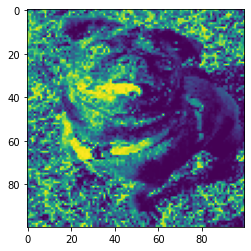

In [44]:
plt.imshow(x[2][0])

In [45]:
y[2]

'pug'

In [46]:
x = x.float()
y = y
x.shape

torch.Size([64, 3, 100, 100])

In [47]:
x

tensor([[[[173., 164., 168.,  ..., 241., 242., 244.],
          [140., 128., 131.,  ..., 242., 242., 240.],
          [110., 112., 109.,  ..., 241., 243., 247.],
          ...,
          [198., 177., 170.,  ..., 236., 240., 234.],
          [175., 186., 119.,  ..., 242., 240., 236.],
          [ 69.,  97., 135.,  ..., 248., 227., 219.]],

         [[113., 104., 108.,  ..., 227., 225., 225.],
          [ 82.,  73.,  73.,  ..., 243., 242., 242.],
          [ 67.,  69.,  66.,  ..., 237., 246., 241.],
          ...,
          [139., 113., 114.,  ..., 196., 202., 213.],
          [123., 128.,  64.,  ..., 237., 192., 176.],
          [ 32.,  79.,  90.,  ..., 237., 178., 157.]],

         [[ 61.,  52.,  56.,  ..., 154., 156., 156.],
          [ 42.,  32.,  33.,  ..., 173., 178., 177.],
          [ 35.,  35.,  34.,  ..., 166., 177., 179.],
          ...,
          [ 83.,  65.,  67.,  ..., 127., 137., 148.],
          [ 73.,  78.,  23.,  ..., 173., 128., 114.],
          [  6.,  43.,  48.,  ...

In [48]:
x_features = model.features1(x)
x_features.shape

torch.Size([64, 128, 13, 13])

In [49]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([64, 512, 4, 4])

In [50]:
x_features2 = F.relu(x_features2)

In [51]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [52]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [53]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [54]:
y_hat

tensor([[ 0.2768],
        [ 0.9301],
        [-1.2433],
        [ 0.6653],
        [-0.3716],
        [ 0.1550],
        [-1.0612],
        [ 0.1567],
        [-0.2494],
        [ 0.8284],
        [ 0.4033],
        [-0.9915],
        [-1.8238],
        [-0.5068],
        [ 0.5528],
        [ 0.7673],
        [-0.1450],
        [-0.2137],
        [ 0.4374],
        [ 0.8635],
        [ 0.4837],
        [-0.4525],
        [ 1.1897],
        [ 1.0944],
        [ 0.8580],
        [-1.9785],
        [-1.2371],
        [-0.2287],
        [-0.5992],
        [ 0.2347],
        [ 0.9439],
        [ 0.9857],
        [ 0.0425],
        [ 0.5883],
        [-0.2928],
        [-0.1361],
        [-0.5083],
        [ 0.7368],
        [-0.2131],
        [-0.5759],
        [-0.2774],
        [-0.2175],
        [ 0.2986],
        [ 0.4528],
        [ 0.5429],
        [-0.0078],
        [ 0.0580],
        [-0.4120],
        [-0.6711],
        [-0.0814],
        [ 0.0040],
        [ 1.0830],
        [ 0.